In [1]:
import math
import numpy as np
import scipy as sp
from scipy.linalg import eigh, eig
from numpy import sin, cos, abs, exp, sqrt, arccos, pi
from scipy.sparse import csc_matrix

%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format ="retina"
import matplotlib as mpl
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
U = 0.0 # Kerr non-linearity
gamma = 5e-2 # Loss rate
J = 1.0 # Tunneling
Nx = 100 # Number of cavities in the vertical direction
Ny = 100 # Number of cavities in the horizontal direction
N = Nx*Ny # Total number of lattice sites
F_i = 1.0 # Pump

# Momenta
kx_list = np.arange(-pi, pi + 2*pi/Nx, 2*pi/Nx)
ky_list = np.arange(-pi, pi + 2*pi/Ny, 2*pi/Ny)

# Detuning
Delta_list_ldos = np.linspace(-4, 4, 25)

# Distance
d = 1

In [3]:
Delta_list = np.linspace(-4, 4, 25)

N = 50 # Number of cavities in the vertical direction
M = 50 # Number of cavities in the horizontal direction

T = np.zeros((N, M, N, M), dtype=np.float64)

for j in range(N):
    for k in range(M-1):

        T[j, k+1, j, k] = J
        T[j, k, j, k+1] = J

for j in range(N-1):
    for k in range(M):

        T[j+1, k, j, k] = J
        T[j, k, j+1, k] = J

def f_RK4(Delta, U, gamma, F, a):

    y = -1.0j * (
        -Delta*a + U*abs(a)**2*a + np.einsum('nmjk,jk->nm', T, a) - 1.0j*gamma*a + F
    )
    
    return y

N_t = 1e3 # Number of time steps
t_f = 1e2 # Final time
t = np.linspace(0, t_f, int(N_t))
Delta_t = t[1] - t[0]

In [11]:
localization_list = ['no', 'yes'] # 'yes' # 'no'

ldos_matrix = []
I_matrix = []
lambda_list = []

for localization in localization_list:

    if localization=='no':
        F = np.zeros((N, M), dtype=np.complex128)
        F[int(N/2), int(M/2)] = 1.0 # Central pump
    elif localization=='yes':
        F = np.zeros((N, M), dtype=np.complex128)
        F[int(N/2), int(M/2-1)] = F_i
        F[int(N/2-1), int(M/2)] = F_i
        F[int(N/2), int(M/2+1)] = F_i
        F[int(N/2+1), int(M/2)] = F_i

    I_list = []

    # Cavity fields
    a = np.zeros((N, M, int(N_t)), dtype=np.complex128)

    count = 0

    for Delta in Delta_list:

        print('{:} / {:}'.format(count+1, len(Delta_list)))

        for i_t in range(len(t)-1):

            k1 = f_RK4(Delta, U, gamma, F, a[:, :, i_t])
            k2 = f_RK4(Delta, U, gamma, F, a[:, :, i_t] + k1*Delta_t/2)
            k3 = f_RK4(Delta, U, gamma, F, a[:, :, i_t] + k2*Delta_t/2)
            k4 = f_RK4(Delta, U, gamma, F, a[:, :, i_t] + k3*Delta_t)

            a[:, :, i_t+1] = a[:, :, i_t] + (k1 + 2*k2 + 2*k3 + k4)*Delta_t/6

        I_list.append( np.sum(np.abs(a[:, :, -1])**2) )
        
        count += 1

    I_matrix.append(I_list)

1 / 25


KeyboardInterrupt: 

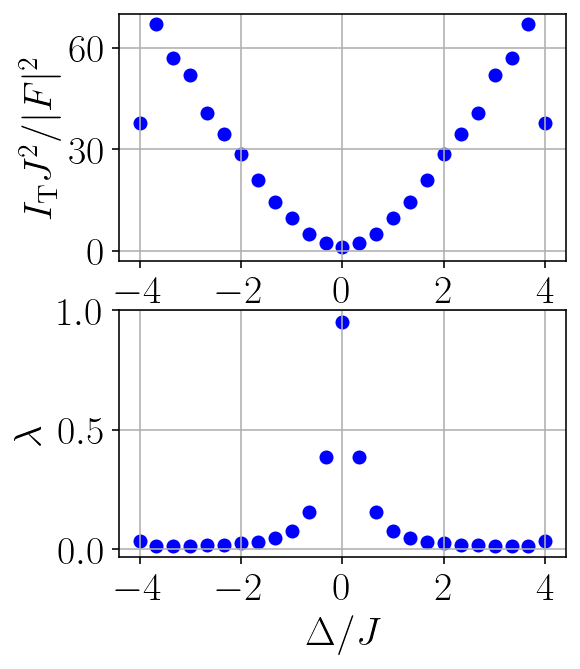

In [8]:
plt.rcParams["figure.figsize"] = [4, 5]
fig, ax = plt.subplots(2, 1)
fs = 20

i_loc = 1
localization = 'yes'

ax[i_loc-1].scatter(Delta_list, np.array(I_matrix[i_loc])*J**2/F_i**2, color='blue', label=r'$\frac{I_{\rm T}J^2}{|F|^2}$')
#ax[i_loc-1].plot(Delta_list_ldos, ldos_matrix[i_loc]*max(np.array(I_matrix[i_loc])*J**2/F_i**2)/max(ldos_matrix[i_loc]), '--k', label=r'$\alpha\Gamma_{\rm e}$')

#ax[i_loc-1].set_xlabel(r'$\Delta/J$', fontsize=fs)
ax[i_loc-1].tick_params(axis='both', labelsize=fs)
#ax[i_loc-1].set_ylabel(r'$I_{\rm T}$', fontsize=fs)
#ax[i_loc-1].set_title('Square lattice', fontsize=fs)
ax[i_loc-1].set_xticks(np.arange(-4, 5, 2))
#ax[i_loc-1].set_xticklabels([])
ax[i_loc-1].grid()

ax[0].set_ylim(-3, 70)
ax[0].set_yticks([0, 30, 60])

ax[0].set_ylabel(r'$I_{\rm T}J^2/|F|^2$', fontsize=fs)

ax[1].grid()
ax[1].scatter(Delta_list, lambda_list, color='blue')
ax[1].set_xlabel(r'$\Delta/J$', fontsize=fs)
ax[1].set_xticks(np.arange(-4, 5, 2))
ax[1].tick_params(axis='both', labelsize=fs)
ax[1].set_yticks(np.arange(0, 1.5, 0.5))
ax[1].set_ylabel(r'$\lambda$', fontsize=fs)